Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


Download NLTK resources

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Data Loading & Exploration

In [4]:

df = pd.read_csv("data/customer_support_tickets.csv")
df.head()
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

Text Cleaning

In [12]:
df['text'] = df['Ticket Subject'] + " " + df['Ticket Description']
df[['Ticket Subject', 'Ticket Description', 'text']].head()


,Ticket Subject,Ticket Description,text
0,Product setup,I'm having an issue with the {product_purchase...,Product setup I'm having an issue with the {pr...
1,Peripheral compatibility,I'm having an issue with the {product_purchase...,Peripheral compatibility I'm having an issue w...
2,Network problem,I'm facing a problem with my {product_purchase...,Network problem I'm facing a problem with my {...
3,Account access,I'm having an issue with the {product_purchase...,Account access I'm having an issue with the {p...
4,Data loss,I'm having an issue with the {product_purchase...,Data loss I'm having an issue with the {produc...


 Visualizing Ticket Categories (Business Context)

C:\Users\Acer\AppData\Local\Temp\ipykernel_11896\1311075097.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Ticket Type', order=df['Ticket Type'].value_counts().index, palette='viridis')


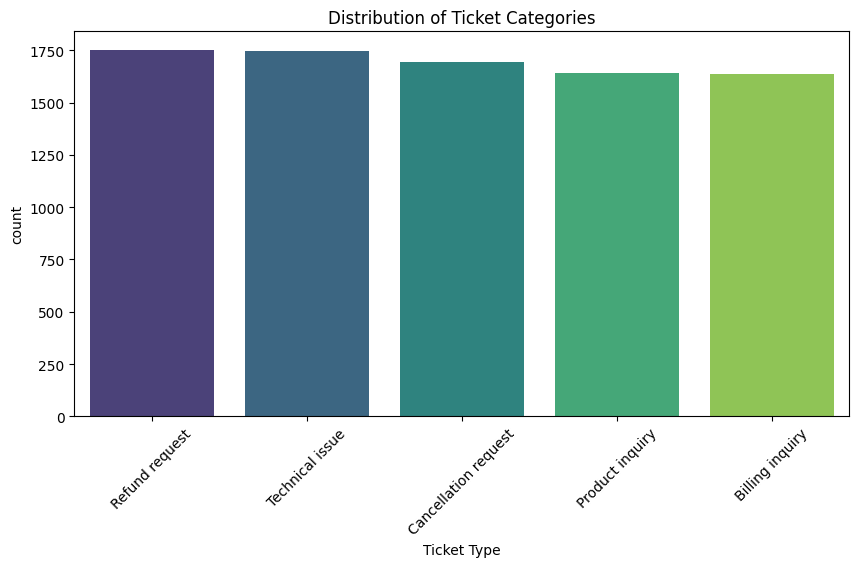

In [ ]:

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='Ticket Type', order=df['Ticket Type'].value_counts().index, palette='viridis')
plt.title('Distribution of Ticket Categories')
plt.xticks(rotation=45)
plt.show()

Text preprocessing pipeline

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['cleaned_text'] = df['text'].apply(clean_text)

df[['text','cleaned_text']].head()

,text,cleaned_text
0,Product setup I'm having an issue with the {pr...,product setup issue product purchased please a...
1,Peripheral compatibility I'm having an issue w...,peripheral compatibility issue product purchas...
2,Network problem I'm facing a problem with my {...,network problem facing problem product purchas...
3,Account access I'm having an issue with the {p...,account access issue product purchased please ...
4,Data loss I'm having an issue with the {produc...,data loss issue product purchased please assis...


Training the Category Model (Ticket Type)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['cleaned_text'])



--- TICKET CATEGORY REPORT ---
                      precision    recall  f1-score   support

     Billing inquiry       0.18      0.12      0.14       357
Cancellation request       0.19      0.21      0.20       327
     Product inquiry       0.18      0.17      0.18       316
      Refund request       0.20      0.23      0.21       345
     Technical issue       0.22      0.24      0.23       349

            accuracy                           0.19      1694
           macro avg       0.19      0.19      0.19      1694
        weighted avg       0.19      0.19      0.19      1694



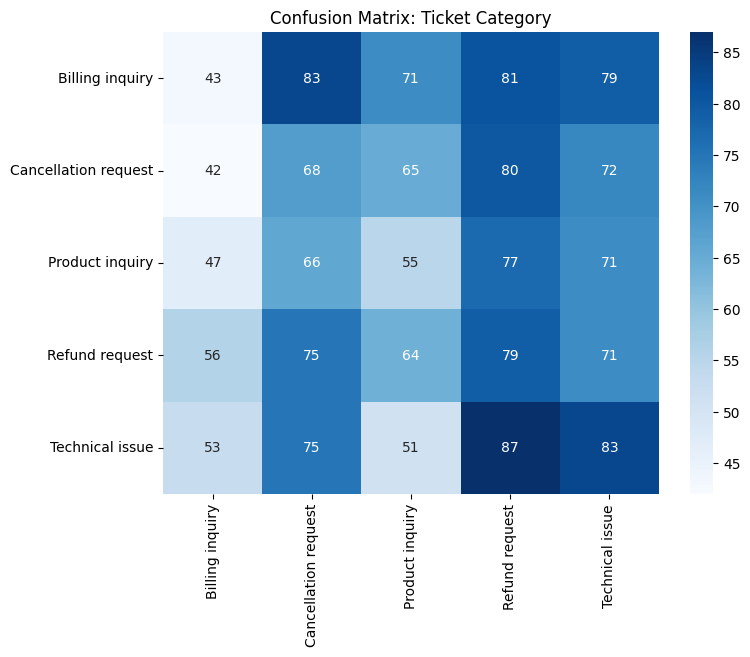

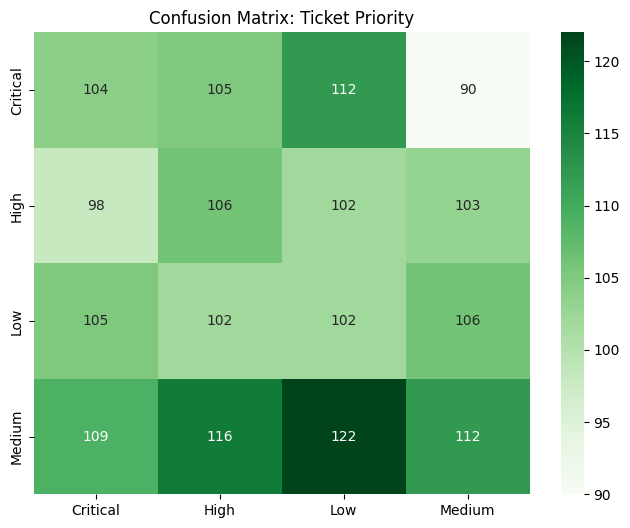

In [29]:
# CATEGORY TARGET
y_category = df['Ticket Type']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_category, test_size=0.2, random_state=42
)

# Model
model_category = LogisticRegression(max_iter=1000)
model_category.fit(X_train, y_train)

# Evaluation
y_pred = model_category.predict(X_test)
print("--- TICKET CATEGORY REPORT ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=model_category.classes_, yticklabels=model_category.classes_)
plt.title('Confusion Matrix: Ticket Category')
plt.savefig('category_cm.png')
plt.show()


# Save the Priority Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_p, y_pred_p), annot=True, fmt='d', cmap='Greens', 
            xticklabels=model_priority.classes_, yticklabels=model_priority.classes_)
plt.title('Confusion Matrix: Ticket Priority')
plt.savefig('priority_cm.png') # This creates the second file for your post
plt.show()

Training the Priority Model

In [17]:
y_priority = df['Ticket Priority']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_priority, test_size=0.2, random_state=42)

model_priority = LogisticRegression(max_iter=1000, class_weight='balanced')
model_priority.fit(X_train_p, y_train_p)

y_pred_p = model_priority.predict(X_test_p)
print("--- TICKET PRIORITY REPORT ---")
print(classification_report(y_test_p, y_pred_p))

--- TICKET PRIORITY REPORT ---
              precision    recall  f1-score   support

    Critical       0.25      0.25      0.25       411
        High       0.25      0.26      0.25       409
         Low       0.23      0.25      0.24       415
      Medium       0.27      0.24      0.26       459

    accuracy                           0.25      1694
   macro avg       0.25      0.25      0.25      1694
weighted avg       0.25      0.25      0.25      1694



Live Prediction Testing (Decision Support)

In [23]:
def predict_ticket(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    
    cat = model_category.predict(vectorized)[0]
    prio = model_priority.predict(vectorized)[0]
    
    print(f"Input Ticket: {text}")
    print(f"Result: [Category: {cat}] | [Priority: {prio}]")
    print("-" * 50)

# Test with various scenarios
predict_ticket("My account is locked and I need to access my files immediately for a meeting!")
predict_ticket("How do I update my billing address for the next invoice?")

Input Ticket: My account is locked and I need to access my files immediately for a meeting!
Result: [Category: Technical issue] | [Priority: Critical]
--------------------------------------------------
Input Ticket: How do I update my billing address for the next invoice?
Result: [Category: Technical issue] | [Priority: High]
--------------------------------------------------


Cross-Validation for Ticket Category and priority

In [25]:
from sklearn.model_selection import cross_val_score

# 1. Cross-Validation for Ticket Category
print("Calculating Cross-Validation scores for Category...")
cv_scores_cat = cross_val_score(model_category, X, y_category, cv=5)

print(f"Category CV Scores: {cv_scores_cat}")
print(f"Mean Category Accuracy: {cv_scores_cat.mean():.4f}")
print(f"Standard Deviation: {cv_scores_cat.std():.4f}")

print("-" * 30)

# 2. Cross-Validation for Ticket Priority
print("Calculating Cross-Validation scores for Priority...")
cv_scores_prio = cross_val_score(model_priority, X, y_priority, cv=5)

print(f"Priority CV Scores: {cv_scores_prio}")
print(f"Mean Priority Accuracy: {cv_scores_prio.mean():.4f}")
print(f"Standard Deviation: {cv_scores_prio.std():.4f}")

Calculating Cross-Validation scores for Category...
Category CV Scores: [0.18831169 0.2107438  0.19126328 0.20661157 0.19610159]
Mean Category Accuracy: 0.1986
Standard Deviation: 0.0087
------------------------------
Calculating Cross-Validation scores for Priority...
Priority CV Scores: [0.26505313 0.22432113 0.25737898 0.25206612 0.26580035]
Mean Priority Accuracy: 0.2529
Standard Deviation: 0.0152


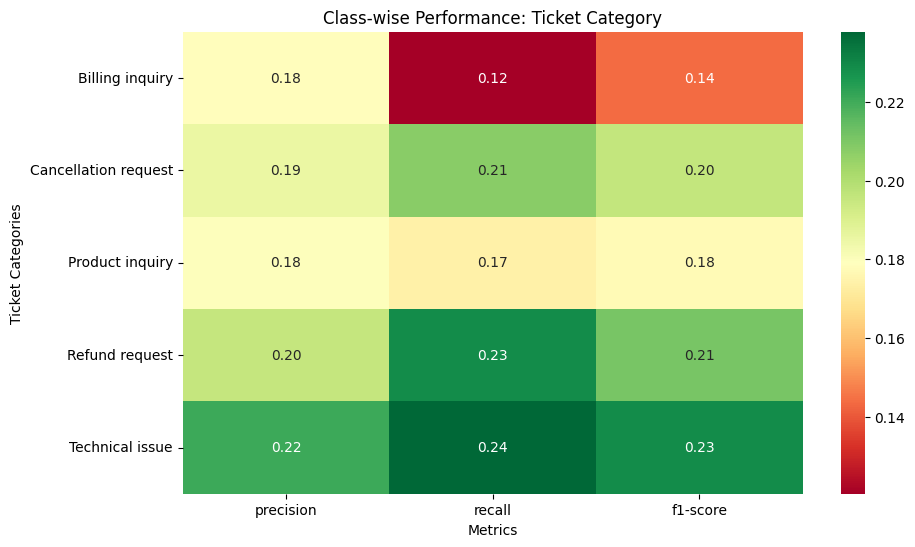

Visualization saved as: ticket_category_performance.png


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_classification_report(y_true, y_pred, title):
    # 1. Generate the report as a dictionary
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # 2. Convert to DataFrame and remove averages for individual class focus
    report_df = pd.DataFrame(report).iloc[:-1, :].T
    report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')

    # 3. Plotting
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap='RdYlGn', fmt='.2f', cbar=True)
    plt.title(f'Class-wise Performance: {title}')
    plt.xlabel('Metrics')
    plt.ylabel('Ticket Categories')
    
    # Save the figure for your portfolio
    file_name = f"{title.lower().replace(' ', '_')}_performance.png"
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()
    print(f"Visualization saved as: {file_name}")

# --- Execute for both models using your actual variable names ---

# 1. For Ticket Category (Using 'y_test' and 'y_pred' from your Category cell)
plot_classification_report(y_test, y_pred, "Ticket Category")

